In [1]:
from os import makedirs, path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import os

#Importing libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import torch.nn.functional as F
import cv2

In [2]:
from google.colab import files
files.upload()


# Use makedirs with exist_ok, it's available in older versions and works like mkdir with exist_ok
makedirs(name=path.expanduser('~/.kaggle'), mode=0o777, exist_ok=True)

# Continue with your code...
!cp kaggle.json ~/.kaggle/

#permission
!chmod 600 ~/.kaggle/kaggle.json


! kaggle datasets download murtozalikhon/brain-tumor-multimodal-image-ct-and-mri
! unzip /content/brain-tumor-multimodal-image-ct-and-mri.zip


Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (10).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (100).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1000).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1001).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1002).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1003).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1004).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1005).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1006).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1007).jpg  
  inflating: Dataset/Brain Tumor MRI images/Healthy/mri_healthy (1008).jpg  
  inflating: Dataset/Brain Tumo

In [3]:

root = "/content/Dataset"
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])
# Calculate mean and std for your dataset
dataset = datasets.ImageFolder(root=root,transform=transform )

loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
mean = 0.
std = 0.
for images, _ in loader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(loader.dataset)
std /= len(loader.dataset)

print(f"Mean: {mean.item()}, Std: {std.item()}")

Mean: 0.2234388291835785, Std: 0.24283750355243683


In [4]:
normalize=transforms.Normalize(mean=mean.item(),std=std.item())
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    normalize])

random_augmentation = transforms.RandomApply(nn.ModuleList([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomPerspective(),
    transforms.RandomRotation((60, 300)),
    transforms.RandomErasing(scale=(0.01, 0.1), p=0.3),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5))
]))

from sklearn.model_selection import train_test_split

# Get targets (labels) from the dataset
targets = [target for _, target in dataset]

# Split into train and remaining (val + test)
train_indices, remaining_indices, _, _ = train_test_split(
    range(len(dataset)), targets, test_size=0.2, stratify=targets, random_state=42
)

# Split remaining into validation and test
val_indices, test_indices, _, _ = train_test_split(
    remaining_indices, [targets[i] for i in remaining_indices], test_size=0.5, stratify=[targets[i] for i in remaining_indices], random_state=42
)

# Create subsets
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

# Convert Train_data to Agumented Dataset
class AugmentedDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.dataset)

# wrap datasets in Dataloder
train_loader = DataLoader(AugmentedDataset(train_dataset, random_augmentation), batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Training set size:", len(train_dataset))
print("Validation set size:", len(val_dataset))
print("Testing set size:", len(test_dataset))




Training set size: 7694
Validation set size: 962
Testing set size: 962


In [5]:
import timm
import torch.nn as nn
from torchvision import models

In [6]:
class EnsembleModel(nn.Module):
  def __init__(self, models, ensemble_method="weighted", weights=None):
    super(EnsembleModel, self).__init__()
    self.models = nn.ModuleList(models)
    self.ensemble_method = ensemble_method
    self.weights = weights

    # Initialize weights if not provided for the "weighted" method
    if self.ensemble_method == "weighted" and self.weights is None:
        self.weights = nn.Parameter(torch.ones(len(self.models)) / len(self.models)) #Fixed nn.Paramter to nn.Parameter

  def forward(self, x):
    outputs = [model(x) for model in self.models]
    if self.ensemble_method == "simple":
        return torch.mean(torch.stack(outputs), dim=0)
    elif self.ensemble_method == "weighted":
        weights = F.softmax(self.weights, dim=0)
        return torch.sum(torch.stack([output * weight for output, weight in zip(outputs, weights)]), dim=0)
    elif self.ensemble_method == "geometric":
        # Convert logits to probabilities
        probs = [F.softmax(out, dim=1) for out in outputs]
        geometric_mean = torch.exp(torch.mean(torch.stack([torch.log(p + 1e-9) for p in probs]), dim=0))
        return torch.log(geometric_mean)
    else:
        raise ValueError("Invalid ensemble method.")

In [7]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
model1=timm.create_model('vit_base_patch16_224',pretrained=True).to(device)
# Access and modify the first convolutional layer of model1
model1.patch_embed.proj = nn.Conv2d(1, 768, kernel_size=(16, 16), stride=(16, 16)).to(device)
model2=timm.create_model('efficientnet_b0',pretrained=True).to(device)
#Change the first layer of model2 to take in a single channel
model2.conv_stem=nn.Conv2d(1,32,kernel_size=(3,3),stride=(2,2),padding=(1,1),bias=False).to(device)

model3=models.resnet18(pretrained=True).to(device)
#Change the first layer of model3 to take in a single channel
model3.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).to(device)

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 161MB/s]


In [9]:
def train_model(model, train_loader, val_loader, num_epochs=10, model_name='model'):
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
    best_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = F.cross_entropy(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        val_correct = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        if val_acc > best_acc:
            torch.save(model.state_dict(), f'best_{model_name}.pth')
            best_acc = val_acc

        scheduler.step()
        print(f'{model_name} Epoch {epoch+1}/{num_epochs}, Val Acc: {val_acc:.4f}')



In [10]:

# Train all base models
train_model(model1, train_loader, val_loader, num_epochs=10, model_name='vit_base')
train_model(model2, train_loader, val_loader, num_epochs=10, model_name='efficient_bo')
train_model(model3, train_loader, val_loader, num_epochs=10, model_name='resnet')

vit_base Epoch 1/10, Val Acc: 0.9854
vit_base Epoch 2/10, Val Acc: 0.9699
vit_base Epoch 3/10, Val Acc: 0.9896
vit_base Epoch 4/10, Val Acc: 0.9938
vit_base Epoch 5/10, Val Acc: 0.9958
vit_base Epoch 6/10, Val Acc: 0.9917
vit_base Epoch 7/10, Val Acc: 0.9896
vit_base Epoch 8/10, Val Acc: 0.9958
vit_base Epoch 9/10, Val Acc: 0.9958
vit_base Epoch 10/10, Val Acc: 0.9969
efficient_bo Epoch 1/10, Val Acc: 0.9979
efficient_bo Epoch 2/10, Val Acc: 0.9979
efficient_bo Epoch 3/10, Val Acc: 0.9969
efficient_bo Epoch 4/10, Val Acc: 0.9969
efficient_bo Epoch 5/10, Val Acc: 0.9969
efficient_bo Epoch 6/10, Val Acc: 0.9979
efficient_bo Epoch 7/10, Val Acc: 0.9979
efficient_bo Epoch 8/10, Val Acc: 0.9979
efficient_bo Epoch 9/10, Val Acc: 0.9979
efficient_bo Epoch 10/10, Val Acc: 0.9979
resnet Epoch 1/10, Val Acc: 0.9979
resnet Epoch 2/10, Val Acc: 0.9979
resnet Epoch 3/10, Val Acc: 0.9969
resnet Epoch 4/10, Val Acc: 0.9979
resnet Epoch 5/10, Val Acc: 0.9979
resnet Epoch 6/10, Val Acc: 0.9979
resnet E

In [11]:
# Load trained models
model1.load_state_dict(torch.load('best_vit_base.pth'))
model2.load_state_dict(torch.load('best_efficient_bo.pth'))
model3.load_state_dict(torch.load('best_resnet.pth'))

models = [model1, model2, model3]

# Create ensemble
ensemble = EnsembleModel(models=models, ensemble_method='weighted').to(device)


Accuracy: 0.9969
ROC-AUC: 0.9980
Precision: 0.9980
Recall: 0.9960
F1-Score: 0.9970


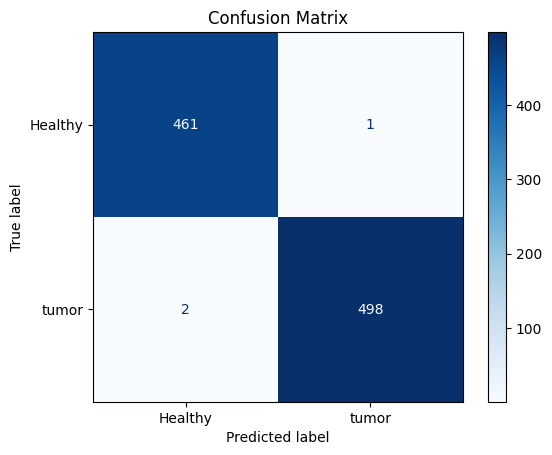

In [12]:
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

def evaluate_ensemble(ensemble, test_loader):
    ensemble.eval()
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = ensemble(images)

            # Get predicted class and probabilities
            probs = F.softmax(outputs, dim=1)  # Softmax for probabilities
            preds = torch.argmax(outputs, dim=1)  # Predicted class

            # Store results
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Convert to numpy arrays
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    # Calculate metrics
    accuracy = (all_preds == all_labels).mean()
    roc_auc = roc_auc_score(all_labels, all_probs[:, 1])  # For binary classification
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = [ 'Healthy', 'tumor'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

    return {
        "accuracy": accuracy,
        "roc_auc": roc_auc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "confusion_matrix": cm
    }

# Evaluate ensemble
metrics = evaluate_ensemble(ensemble, test_loader)